# Attributable heatwaves paper: development script

### step 1: find present day warming in models

find present day warming window in models

- pick present-day warming window from literature target, step 3 option 2 (*) 
- look at observations (ERA5 or other) to validate models. Look regionally? Cold bias over Europe cfr to obs?
- for step 3 option 1 select only models that are within +/- 0.2 deg C of observed GMST warming. 


To do: this is now in another script, make a function and move it there to automate everything

### step 2: calculate pre-industrial TX99 (p0)

calculate grid cell percentiles from ISIMIP3b historical tasmax data from a baseline period 1850-1900, get baseline thresholds (p0, Xth)

note. alternative heat metrics 
- TX99 pi probability of exceedance is 0.01 by definition (p0 = Xthreshold) (*)
- HWMId
- 3dTX>90p with p90 from mid-20th century (e.g. 1960-1980)

note. possibilities to define p0
1) hist 1850-1900 (*)
2) hist-nat 1850-1900
3) present-day hist-nat (1970-2020?)

### step 3: calculate probability of TX99 threshold exceedance in present-day in models (p1)

1) a world that has warmed to today's levels (30-year average warming AR6 method 1.15 deg C wrt 1850-1900, Forster 2023), historical + ssp3-rcp7, window from modeleval output (*)
2) present day years (2001-2020), after model evaluation

To do: check this definition of present-day warming is ok 

### step 4: calculate number of attributable events 

n_attr = n_days (p1-p0)

note. alternative possibilities
1) hist present-day warming vs. hist 1850-1900 (*)
2) hist present-day warming vs. hist-nat same time-window

### step 5: combine with demographic data  


## Next steps 

step 5, aggregate model results mean/median as best estimate. 

step 6, aggregate with observations to attribute observed events
- possibility: normal distribution shift fit at each grid cell on observations based on Hauser's shift fit code
- note: if I work on 3dTX90 (incl. to attribute observed heatwaves start from this), from obs to then get p1 in present-day and use this when I move to model world - and determine ToE as when PR>2 and count number of heatwaves that have occurred after this date


## Extensions
- extend to other metrics (e.g. heatwave-like definitions 3dTX > 90th percentile defined in warm season rolling window or statically) and pick most suitable
- repeat analysis with more models, more CMIP models
- attribute observed events
- accumulate number of "attributable heatwaves" over lifetimes of soemone born in 1850, 1960, 2020 (ages of plaintiffs, or do this for all cohorts like Luke did, to have this database accessible! would be useful!!) - extending to future using different warming pathways
- calculate delta-I (if from shift-fit method this should be simple linear function of location parameters !!)
- scientific evaluation of influence of shape of tail / spread of distribution and does this invalidate results
- bootstrapping for uncertainty ?
- model evaluation / weighting 

Different metrics:
- Make rolling avg 3dTX and calc quantile for that
- accumulated metrics based on this (lifetime accumulated metrics?)
- Calc Perkins-Kirkpatrick heatwave metric (maybe crop data over just Europe to make computations go faster) and other metrics they use
- calc HWMId (maybe use R package??) and calc quantile for that  

Extensions/Alternatives:
- warm season heatwave (climatological percentile)
- fit to a GEV and calc PR in GEV-way, for more extreme values than this (see Li 2021 did this, results are in AR6)
- shift fit observations to normal or other distribution

last update December 2023
rosa.pietroiusti@vub.be

In [3]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), openpyxl

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
try:
    import netCDF4
except: # for running in env-geosci lite 
   pass

%matplotlib inline
# import my variables settings functions from other scripts
from settings import *
start_message()

from functions import *
from utils import * 


# can turn flags into a class??
# use object oriented a little more?

indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/ 
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/ 
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0'] 
GCMs p: ['GFDL-ESM4', 'IPSL-CM6A-LR', 'MRI-ESM2-0'] 
GCMs s: ['CanESM5', 'CNRM-CM6-1', 'MIROC6'] 
lat chunk: 90 
lon chunk: 120 
time chunk: -1 
outdir: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output 
figdir: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/figures 
start_pi: 1850 
end_pi: 1900 
flags {'models': 'ISIMIP3b', 'variable': 'TX99'}


In [4]:
from dask.distributed import Client 
client = Client()
client

/apps/brussel/RL8/skylake/software/dask/2022.10.0-foss-2022a/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33875 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33875/status,
Dashboard: http://127.0.0.1:33875/status,Workers: 2
Total threads: 2,Total memory: 20.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35391,Workers: 2
Dashboard: http://127.0.0.1:33875/status,Total threads: 2
Started: Just now,Total memory: 20.00 GiB
Comm: tcp://127.0.0.1:35113,Total threads: 1
Dashboard: http://127.0.0.1:36101/status,Memory: 10.00 GiB
Nanny: tcp://127.0.0.1:38271,


In [5]:
figdir = os.path.join(figdirs, 'fig_dec23-exposure')

## 1. Calculate number of attributable events for different age groups, for a single year (2022)

### Get demographic data for 2022

In [6]:
sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! 

In [7]:
d_countries = preprocess_all_country_population_data()

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated


In [8]:
gs_population_global = get_gridscale_population_global( 
    d_countries,
    startyear=2022,
    endyear=None,
    save=False # change if/where this is saved 
)

calculating gridscale population per country
processing country 191 of 191
elapsed time 1.765326976776123
combining gridscale population globally
processing country 191 of 191
elapsed time 65.87349057197571


In [9]:
gs_population_global.sum()

<xarray.DataArray 'number of people' ()>
array(7.27267342e+09)

In [10]:
print('lost people:',7.770247e+09 - 7.27267342e+09, 'i.e. percent:', (7.770247e+09 - 7.27267342e+09)/7.770247e+09*100)
# in raw isimip data for 2022, in post-processed data
# note! I lose about 500 milion people ! 6% of global population 

lost people: 497573580.0 i.e. percent: 6.403574815575361


### [BUG TO FIX] find missing population

In [14]:
da_population = load_population(2022,2022)
da_population

<xarray.DataArray 'number_of_people' (time: 1, lat: 360, lon: 720)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) int64 2022
Attributes:
    units:    1
    code:     1

Text(0.5, 1.0, 'total = 7.77 bln')

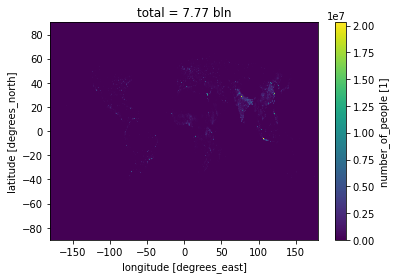

In [41]:
da_population.plot()
plt.title(f'total = {float(da_population.sum())/ (10**9):.2f} bln')

Text(0.5, 1.0, 'total = 7.27 bln')

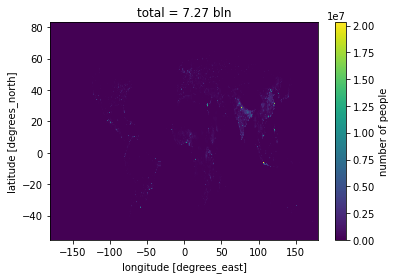

In [53]:
gs_population_global.sum(dim='ages').plot()
tot = float( gs_population_global.sum(dim='ages').sum() ) / 10**9 
plt.title(f'total = {tot:.2f} bln')

Text(0.5, 1.0, 'postprocessed - raw (missing pop=491 mln)')

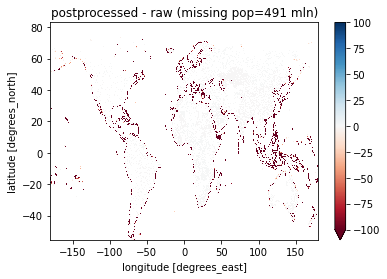

In [80]:
# Calculate the difference between da_population and gs_population_global.sum(dim='ages')
difference = gs_population_global.sum(dim='ages') - da_population

# Use boolean indexing to crop the plot only to areas where values are non-zero
difference_cropped = difference.where(difference != 0)

# Plot the cropped data
vmax=1e2
difference_cropped.plot(vmax=vmax,vmin=-vmax, cmap='RdBu')
plt.title(f'postprocessed - raw (missing pop={-difference.sum()/10**6:.0f} mln)')

In [58]:
difference_cropped.max()

<xarray.DataArray ()>
array(16484000.)

In [59]:
difference_cropped.min()

<xarray.DataArray ()>
array(-1.86264515e-09)

### Number and proportion of age group living through at least n AHD : Functions

To do: integrate the per-year functions ! 

In [11]:
def calc_number_proportion_people_atleastxdays_10yr(gs_population, 
                                                    GCMs,  
                                                    x_hot_days = [1,5,10,20,50], 
                                                    datadir='output_dec23-8736300' ):
    
    # Group the data by age ranges and calculate the sum
    age_ranges = np.arange(0, 105, 10) #0-9 ... 90-99
    grouped_data = gs_population_global.groupby_bins('ages', age_ranges, right=False).sum() # right boundary excluded i.e. [0,9)
    
    # initiate empty dataarray 
    da_master = None
    
    for GCM in GCMs:
        # initiate empty dataframe
        columns = {f'n_atleast_{x}': np.nan for x in x_hot_days}
        columns.update({f'prop_atleast_{x}': np.nan for x in x_hot_days})
        df_out = pd.DataFrame(index=age_ranges[:-1], columns=columns)
        
        # open da_nAHD
        filepath = glob.glob(os.path.join(make_outdir(GCM, makedirs=False, outdirname=datadir), '*nAHD*'))[0]
        da_nAHD = xr.open_dataarray(filepath)
        
        # calculate - loop over each age bin and each threshold 
        for i in range(len(grouped_data.ages_bins)):
            for x in x_hot_days:

                # number of people living through at least x heatwaves 
                n_people_at_least_x = grouped_data.isel(ages_bins=i).where(da_nAHD>=x).sum().values
                df_out.loc[age_ranges[i],f'n_atleast_{x}'] = float(n_people_at_least_x)

                # proportion of people living through at least x heatwaves
                prop_at_least_x = n_people_at_least_x / grouped_data.isel(ages_bins=i).sum().values
                df_out.loc[age_ranges[i],f'prop_atleast_{x}'] = prop_at_least_x
        
        # convert to dataarray
        da = xr.DataArray(df_out, dims = ('age_ranges', 'features')).assign_coords(model=GCM)
        
        # concat for all GCMs
        if da_master is None:
            da_master = da.copy()
        else:
            da_master = xr.concat([da_master, da], dim='model')
    
    da_n_people = da_master.isel(features=slice(0, len(da_master.features) //2))
    da_n_people.name = 'number of people'
    da_prop_people = da_master.isel(features=slice(len(da_master.features) //2, len(da_master.features))) 
    da_prop_people.name = 'proportion'
        
    return da_n_people, da_prop_people

In [17]:
def calc_number_proportion_people_atleastxdays_1yr(gs_population, 
                                                   GCMs, 
                                                   x_hot_days = [1, 5, 10, 20, 50], 
                                                   ages_values=range(0,100), 
                                                   datadir='output_dec23-8736300'):
    #maybe combine into a single function??? that automatically groups data however you want
    # THEN MOVE TO FUNCTIONS.py

    # initiate empty dataarray 
    da_master = None
    
    for GCM in GCMs:
        
        df_out = pd.DataFrame(index=ages_values)

        for x in x_hot_days:
            df_out[f'n_atleast_{x}'] = np.nan
        df_out['n_whrincr'] = np.nan 
        for x in x_hot_days:
            df_out[f'prop_atleast_{x}'] = np.nan
        df_out['prop_whrincr'] = np.nan
        df_out['n_people'] = np.nan

        # open da_nAHD
        filepath = glob.glob(os.path.join(make_outdir(GCM, makedirs=False, outdirname=datadir), '*nAHD*'))[0]
        da_nAHD = xr.open_dataarray(filepath)

        for i in range(len(df_out)):

            for x in x_hot_days:

                # number of people living through at least 1 heatwave 
                n_people_at_least_x = gs_population_global.isel(ages=i).where(da_nAHD>=x).sum().values
                df_out.loc[i,f'n_atleast_{x}'] = n_people_at_least_x

                # proportion of people living through at least 1 heatwave
                prop_at_least_x = n_people_at_least_x / gs_population_global.isel(ages=i).sum().values
                df_out.loc[i,f'prop_atleast_{x}'] = prop_at_least_x

            #greater than zero
            n_whereincr = gs_population_global.isel(ages=i).where(da_nAHD>0).sum().values
            prop_whereincr = n_whereincr / gs_population_global.isel(ages=i).sum().values
            df_out.loc[i,f'n_whrincr'] = n_whereincr
            df_out.loc[i,f'prop_whrincr'] = prop_whereincr

            # total people of each age 
            n_people = gs_population_global.isel(ages=i).sum().values
            df_out.loc[i,f'n_people'] = n_people

        # convert to dataarray
        da = xr.DataArray(df_out, dims = ('age_ranges', 'features')).assign_coords(model=GCM)

        # concat for all GCMs
        if da_master is None:
            da_master = da.copy()
        else:
            da_master = xr.concat([da_master, da], dim='model')

    da_n_people = da_master.isel(features=slice(0, len(da_master.features)//2))
    da_n_people.name = 'number of people'
    da_prop_people = da_master.isel(features=slice(len(da_master.features) //2, len(da_master.features))) 
    da_prop_people.name = 'proportion'


    return da_n_people, da_prop_people




In [13]:
def plot_barplot_n_prop_people_atleastx_modelmean(da, 
                                                  unit, 
                                                  year, 
                                                  ax, 
                                                  proportion=False, 
                                                  x_hot_days = [1,5,10,20,50]):
    # plot range 
    if unit == 1e9:
        unit_str = 'billion'
    elif unit == 1e6:
        unit_str='million'
    else:
        unit_str = ''

    upper_error = (da.max(dim='model')-da.mean(dim='model')).values.T /unit
    lower_error = (da.mean(dim='model')-da.min(dim='model')).values.T /unit
    concatenated =np.concatenate((lower_error,upper_error), axis=1)
    reshaped = np.reshape(concatenated, (len(da.features), 2, len(da.age_ranges)))

    # plot multi-model mean 
    (da.mean(dim='model')/unit).to_pandas().plot.bar(ax=ax,
                                                   yerr=reshaped,
                                                   error_kw=dict(ecolor='gray', alpha=1, elinewidth=.5, capsize=1))
                          
    if proportion ==False:
        ax.set_ylabel(f'number of people ({unit_str})')
        ax.set_title(f'number of people experiencing at least n attributable hot days in {year}')
    else:
        ax.set_ylabel(f'proportion of age group')
        ax.set_title(f'proportion of age group experiencing at least n attributable hot days in {year}')
    
    ax.set_xlabel('ages')
    step_ages = int(da.age_ranges[1] -da.age_ranges[0] - 1)
    ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+step_ages}' for x in da.age_ranges],  rotation='horizontal')
    ax.legend(labels = [f'at least {x}' for x in x_hot_days])
   

### run it 

In [180]:
da_n_people, da_prop_people = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, GCMs)

outdir exists: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_dec23-8736300/TX99/ISIMIP3b/CanESM5
outdir exists: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_dec23-8736300/TX99/ISIMIP3b/CNRM-CM6-1
outdir exists: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_dec23-8736300/TX99/ISIMIP3b/GFDL-ESM4
outdir exists: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_dec23-8736300/TX99/ISIMIP3b/IPSL-CM6A-LR
outdir exists: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_dec23-8736300/TX99/ISIMIP3b/MIROC6
outdir exists: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_dec23-8736300/TX99/ISIMIP3b/MRI-ESM2-0


In [181]:
da_n_people

<xarray.DataArray 'number of people' (model: 6, age_ranges: 10, features: 5)>
array([[[1161833804.5199425, 1035547905.7814429, 751694962.833767,
         367999918.27212363, 67565669.74666643],
        [1119554400.303308, 992706868.8213505, 713000947.9038192,
         349175140.2352553, 66308317.47606766],
        [1042422939.8290061, 916561309.4564263, 644520968.0180491,
         316036725.9880623, 61447853.15116568],
        [1015599785.8631048, 868933837.8196951, 577546605.9273858,
         279489907.57070315, 56073852.254485324],
        [859771102.101619, 728146636.8826267, 469016604.96897894,
         227610262.47001225, 48710354.24231859],
        [734808677.4650348, 604414393.0792464, 360700452.5666465,
         172309282.99478263, 38315040.6263625],
        [532661271.8915191, 431105776.08425677, 243881696.2824476,
         114376964.49701865, 24789717.25161917],
        [295522691.94908196, 235707061.6844492, 123040247.19296291,
         55085514.800005466, 11413059.21156134],
        [113989963.33253527, 90288490.32477902, 42608568.30944747,
         17985875.996789876, 3513145.245366328],
        [20047222.462742075, 15881689.804483952, 6815849.867765695,
         2656368.036150844, 461247.5328722418]],
...
       [[1105526447.4479249, 789431566.3250192, 520404872.47498566,
         239606628.53707305, 57965293.49551602],
        [1058797794.854211, 736316864.8037875, 474052987.09944636,
         219099761.2506484, 55000332.03550778],
        [981648898.2497963, 663954092.7361583, 413013184.91086113,
         190847004.98768538, 50111491.00291966],
        [962200470.7274402, 634008800.3511593, 369848246.96650964,
         169866744.21308514, 44892142.96218559],
        [816362452.9268044, 529256447.45427126, 300846443.36339355,
         136817782.83860153, 37481195.56518738],
        [704164594.0092643, 445018733.49405235, 231183029.41567704,
         99862721.79469544, 28534885.183627255],
        [513223697.0277597, 315539692.35682404, 155207461.2558234,
         64542679.14179864, 18526926.489120476],
        [286403408.6587568, 169408922.9037619, 78435714.51881438,
         31258285.220439304, 8763225.456365217],
        [110531434.39159797, 61905943.99961108, 27199549.513622027,
         10304725.594506605, 2835933.4126082994],
        [19443339.45489953, 10632656.274636293, 4418039.385067757,
         1539288.416372019, 417615.23280970793]]], dtype=object)
Coordinates:
  * age_ranges  (age_ranges) int64 0 10 20 30 40 50 60 70 80 90
  * features    (features) object 'n_atleast_1' 'n_atleast_5' ... 'n_atleast_50'
  * model       (model) <U12 'CanESM5' 'CNRM-CM6-1' ... 'MIROC6' 'MRI-ESM2-0'

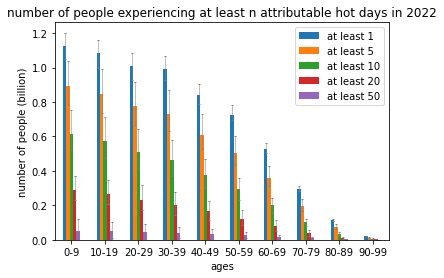

In [317]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx(da_n_people, unit=1e9, year=2022, ax=ax, proportion=False)
plt.legend(labels = [f'at least {x}' for x in x_hot_days])

#plt.savefig(os.path.join(figdir,'n_atleastx_2022_10yr.png'),dpi=300)

In [271]:
(da_n_people.mean(dim='model')/1e6).to_pandas() # milion people 

features,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50
age_ranges,,,,,
0,1125.432132,893.743367,617.088463,287.591965,54.006052
10,1082.731551,847.812287,573.308636,263.071512,50.838780
20,1007.651816,774.551553,509.450565,229.676230,45.863591
30,989.636647,731.767927,460.843066,203.538906,41.000541
40,839.590723,610.738528,375.837860,164.453940,34.375605
50,725.483340,505.677229,293.373963,123.397038,26.242015
60,525.896159,359.304490,199.442218,80.755526,17.015291
70,292.336449,194.408560,102.357794,39.285651,8.119012
80,112.344903,72.719403,35.936125,12.909668,2.621356


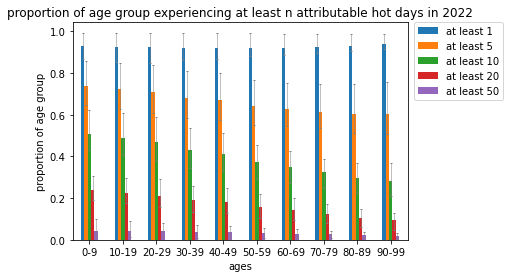

In [307]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx(da_prop_people, unit=1, year=2022, ax=ax, proportion=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, labels = [f'at least {x}' for x in x_hot_days])

#plt.savefig(os.path.join(figdir,'prop_atleastx_2022_10yr.png'),dpi=300)

In [311]:
da_prop_people.mean(dim='model').to_pandas()

features,prop_atleast_1,prop_atleast_5,prop_atleast_10,prop_atleast_20,prop_atleast_50
age_ranges,,,,,
0,0.930375,0.738842,0.510136,0.237747,0.044646
10,0.926954,0.725834,0.490824,0.225222,0.043524
20,0.924399,0.710558,0.467360,0.210700,0.042074
30,0.920966,0.680991,0.428865,0.189415,0.038156
40,0.921123,0.670047,0.412335,0.180424,0.037714
50,0.918952,0.640529,0.371610,0.156304,0.033240
60,0.920923,0.629196,0.349253,0.141415,0.029796
70,0.924772,0.614988,0.323797,0.124275,0.025684
80,0.931340,0.602844,0.297911,0.107021,0.021731


### [TO FINISH] the same but for each age

Maybe combine the two functions so automatically it calculates for whatever groupsize you want.... 

In [18]:
da_n_people_yr, da_prop_people_yr = calc_number_proportion_people_atleastxdays_1yr(gs_population_global, GCMs)

In [19]:
da_n_people_yr

<xarray.DataArray 'number of people' (model: 6, age_ranges: 100, features: 6)>
array([[[1.15631682e+08, 1.03582070e+08, 7.59532473e+07, 3.71449820e+07,
         6.65236568e+06, 1.17340153e+08],
        [1.15754282e+08, 1.03576008e+08, 7.57790804e+07, 3.70683175e+07,
         6.67552153e+06, 1.17502711e+08],
        [1.15876881e+08, 1.03569946e+08, 7.56049135e+07, 3.69916530e+07,
         6.69867737e+06, 1.17665268e+08],
        ...,
        [6.66420944e+05, 5.33122476e+05, 2.26222749e+05, 8.78655144e+04,
         1.41118248e+04, 6.78962154e+05],
        [5.53493017e+05, 4.43180398e+05, 1.88849170e+05, 7.36680637e+04,
         1.17918825e+04, 5.63874182e+05],
        [4.40565090e+05, 3.53238321e+05, 1.51475591e+05, 5.94706130e+04,
         9.47194021e+03, 4.48786210e+05]],

       [[1.14500275e+08, 9.12077323e+07, 6.45563718e+07, 2.87602683e+07,
         2.41489210e+06, 1.17762230e+08],
        [1.14577139e+08, 9.10680680e+07, 6.43305809e+07, 2.86214553e+07,
         2.42236901e+06, 1.17895429e+08],
        [1.14654003e+08, 9.09284037e+07, 6.41047900e+07, 2.84826423e+07,
         2.42984592e+06, 1.18028629e+08],
...
        [6.35187322e+05, 3.71063319e+05, 1.89452215e+05, 9.29755558e+04,
         2.26458427e+04, 6.55103681e+05],
        [5.27271532e+05, 3.08568105e+05, 1.57980750e+05, 7.78111771e+04,
         1.90525811e+04, 5.43837424e+05],
        [4.19355742e+05, 2.46072891e+05, 1.26509284e+05, 6.26467984e+04,
         1.54593195e+04, 4.32571166e+05]],

       [[1.10045676e+08, 7.92709978e+07, 5.28980906e+07, 2.43048901e+07,
         5.82063027e+06, 1.12369225e+08],
        [1.10158335e+08, 7.91981442e+07, 5.27075120e+07, 2.42283951e+07,
         5.81527451e+06, 1.12504246e+08],
        [1.10270995e+08, 7.91252906e+07, 5.25169335e+07, 2.41519002e+07,
         5.80991875e+06, 1.12639268e+08],
        ...,
        [6.44009209e+05, 3.55429233e+05, 1.47842052e+05, 5.14656539e+04,
         1.40153111e+04, 6.56390686e+05],
        [5.34627815e+05, 2.95847863e+05, 1.23393890e+05, 4.31237137e+04,
         1.17200977e+04, 5.44895972e+05],
        [4.25246420e+05, 2.36266493e+05, 9.89457278e+04, 3.47817734e+04,
         9.42488428e+03, 4.33401258e+05]]])
Coordinates:
  * age_ranges  (age_ranges) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * features    (features) object 'n_atleast_1' 'n_atleast_5' ... 'n_whrincr'
  * model       (model) <U12 'CanESM5' 'CNRM-CM6-1' ... 'MIROC6' 'MRI-ESM2-0'

In [20]:
da_prop_people_yr

<xarray.DataArray 'proportion' (model: 6, age_ranges: 100, features: 7)>
array([[[9.62982240e-01, 8.62632909e-01, 6.32539689e-01, ...,
         5.54009930e-02, 9.77210410e-01, 1.20076651e+08],
        [9.62420196e-01, 8.61165917e-01, 6.30052870e-01, ...,
         5.55025408e-02, 9.76957226e-01, 1.20274161e+08],
        [9.61859995e-01, 8.59703736e-01, 6.27574205e-01, ...,
         5.56037555e-02, 9.76704871e-01, 1.20471671e+08],
        ...,
        [9.65109090e-01, 7.72066592e-01, 3.27615202e-01, ...,
         2.04367083e-02, 9.83271238e-01, 6.90513592e+05],
        [9.65218160e-01, 7.72847633e-01, 3.29327820e-01, ...,
         2.05634738e-02, 9.83321529e-01, 5.73438255e+05],
        [9.65383190e-01, 7.74029411e-01, 3.31919148e-01, ...,
         2.07552801e-02, 9.83397625e-01, 4.56362919e+05]],

       [[9.53559864e-01, 7.59579251e-01, 5.37626353e-01, ...,
         2.01112547e-02, 9.80725469e-01, 1.20076651e+08],
        [9.52633034e-01, 7.57170677e-01, 5.34866179e-01, ...,
         2.01403942e-02, 9.80222422e-01, 1.20274161e+08],
        [9.51709243e-01, 7.54770002e-01, 5.32115054e-01, ...,
         2.01694381e-02, 9.79721024e-01, 1.20471671e+08],
...
        [9.19876640e-01, 5.37372940e-01, 2.74364209e-01, ...,
         3.27956509e-02, 9.48719459e-01, 6.90513592e+05],
        [9.19491379e-01, 5.38101708e-01, 2.75497402e-01, ...,
         3.32251658e-02, 9.48380089e-01, 5.73438255e+05],
        [9.18908449e-01, 5.39204393e-01, 2.77212015e-01, ...,
         3.38750562e-02, 9.47866596e-01, 4.56362919e+05]],

       [[9.16461903e-01, 6.60169961e-01, 4.40536027e-01, ...,
         4.84742890e-02, 9.35812450e-01, 1.20076651e+08],
        [9.15893609e-01, 6.58480122e-01, 4.38228058e-01, ...,
         4.83501565e-02, 9.35398306e-01, 1.20274161e+08],
        [9.15327179e-01, 6.56795823e-01, 4.35927657e-01, ...,
         4.82264310e-02, 9.34985520e-01, 1.20471671e+08],
        ...,
        [9.32652473e-01, 5.14731698e-01, 2.14104478e-01, ...,
         2.02969373e-02, 9.50583297e-01, 6.90513592e+05],
        [9.32319757e-01, 5.15919300e-01, 2.15182522e-01, ...,
         2.04382906e-02, 9.50226057e-01, 5.73438255e+05],
        [9.31816331e-01, 5.17716237e-01, 2.16813689e-01, ...,
         2.06521693e-02, 9.49685524e-01, 4.56362919e+05]]])
Coordinates:
  * age_ranges  (age_ranges) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * features    (features) object 'prop_atleast_1' ... 'n_people'
  * model       (model) <U12 'CanESM5' 'CNRM-CM6-1' ... 'MIROC6' 'MRI-ESM2-0'

### Person x days : CAHD, AAHD and per capita